## Import necessary modules

In [18]:
import time
import pandas as pd
import numpy as np
import datetime as dt
from collections import OrderedDict
from copy import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

## Filepath management

In [19]:
project_dir = r'/Users/hudson/Code/marketModel/'

## Load the data from the hdf store

In [20]:
stock_data = pd.read_hdf(project_dir + 'data/stock_data/raw_stock_data.hdf', 'table')
symbols = stock_data.reset_index().ticker.unique()
pprint(symbols)

array(['ASTC', 'PAVM', 'CODA', 'WSTL', 'MICR', 'SEAC', 'GBR', 'CPST',
       'CYAN', 'ATLC', 'WTT', 'LRAD', 'DTRM', 'AVIR', 'UTSI', 'JCS',
       'ZDGE', 'REFR', 'FORD', 'APHB', 'JVA', 'VSR', 'BNSO', 'ARDM', 'LEU',
       'MOC'], dtype=object)


In [21]:
stock_data.head()

open    high     low   close  volume
ticker timestamp                                                  
ASTC   2017-08-08 14:47:00  0.7311  0.7311  0.7311  0.7311    1000
       2017-08-08 14:57:00  0.7500  0.7500  0.7500  0.7500     300
       2017-08-08 15:04:00  0.7600  0.7600  0.7600  0.7600     100
       2017-08-08 15:33:00  0.7301  0.7301  0.7301  0.7301     100
       2017-08-08 15:34:00  0.7400  0.7401  0.7250  0.7250   18677

## Visualize the data

In [22]:
symbol = np.random.choice(symbols)
print 'symbol: ' + symbol
stock_data_vis = stock_data.loc[symbol]
print stock_data_vis.head()
print stock_data_vis.describe()

symbol: DTRM
                      open   high    low  close  volume
timestamp                                              
2017-08-08 13:30:00  2.000  2.000  1.995  1.995    3300
2017-08-08 13:31:00  2.000  2.000  2.000  2.000    1800
2017-08-08 13:32:00  2.000  2.000  2.000  2.000     600
2017-08-08 13:36:00  2.070  2.070  2.070  2.070     100
2017-08-08 13:53:00  2.018  2.018  2.018  2.018     500
             open        high         low       close         volume
count  656.000000  656.000000  656.000000  656.000000     656.000000
mean     1.909094    1.913177    1.906054    1.909924    1579.981707
std      0.137448    0.136942    0.138241    0.137864   21134.392264
min      1.600000    1.600000    1.580000    1.600000     100.000000
25%      1.850000    1.850000    1.850000    1.850000     100.000000
50%      1.951850    1.960000    1.950000    1.950000     200.000000
75%      2.000000    2.009250    2.000000    2.006775     600.000000
max      2.120000    2.120000    2.120000  

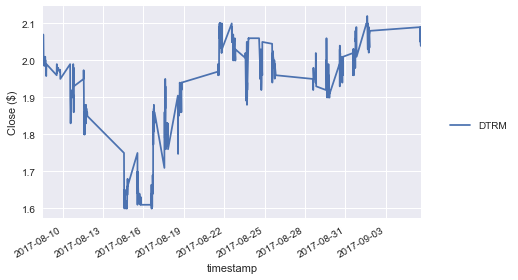

In [23]:
# First keep the time index so we can see the time frame
stock_data_vis.close.plot(label=symbol)

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

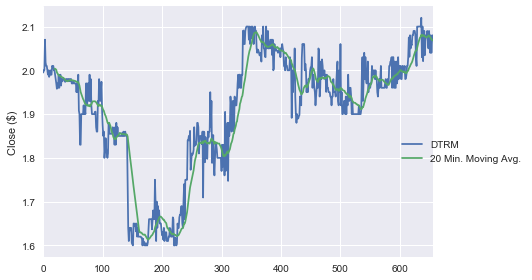

In [24]:
# Now drop the time index so we can see the actual stock movement
stock_data_vis.reset_index().close.plot(label=symbol)
stock_data_vis.reset_index().close.rolling(20).mean().plot(label='20 Min. Moving Avg.')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

## Logic for getting goal information

In [104]:
def get_min_max(data, starttime, endtime):
    """
    This function takes data for a specific ticker and returns the min and max prices.
    """
    subdata = data.loc[starttime:endtime]
    
    return (subdata.low.min(), subdata.high.max())
    
def is_goal_met(data, timestep, goal_time_from_step, goal_duration, goal_raise_frac = 0.1, goal_drop_frac=0.1):
    """
    This function takes data for a specific ticker, a time index for that ticker, goal parameters, and 
    returns a boolean indicating whether or not the goal is satisfied for that timestep.
    """
    
    # Convert time variables to appropriate numpyt date types
    td_goal_time_from_step = np.timedelta64(goal_time_from_step, 'm')
    td_goal_duration = np.timedelta64(goal_duration, 'm')
    
    # Calculate the start and end times of the goal time window
    goal_starttime = np.datetime64(timestep + td_goal_time_from_step)
    goal_endtime = np.datetime64(goal_starttime + td_goal_duration)

    # Get the data for goal checking in that time window
    subdata = data.loc[goal_starttime:goal_endtime]
    
    # Get the minimum and maximum prices for the goal time window
    min_price, max_price = get_min_max(data, goal_starttime, goal_endtime)
    if np.isnan(min_price) | np.isnan(max_price):
        # Zero trading volume in time window. Get last prices.
        most_recent_time_with_transactions = np.max(data.loc[:goal_starttime].index)
        if most_recent_time_with_transactions == timestep:
            return {'timestamp': timestep,
                    'goal_met': False,
                    'raise_goal_met': False,
                    'drop_goal_met': True,
                     'statusMessage': 'Zero trading volume since current timestep'}
        else:
            min_price, max_price = data.loc[timestep, 'low'], data.loc[timestep, 'high']
        
        
    # Determine if goals were met
    # TODO: is this the right reference for the 'current price'?
    current_price = np.mean(data.loc[timestep, ['high', 'close']])
    
    # Is raise goal met? Return true if max price at least (1+goal_raise_frac) * current_price
    is_raise_goal_met = max_price >= (1+goal_raise_frac) * current_price
    
    # Is drop goal met? Return true if min price at least (1-goal_drop_frac) * current_price
    is_drop_goal_met = min_price >= (1-goal_drop_frac) * current_price
    
    # Return dict containing raise and drop goals and product for convenience
    return {'timestamp': timestep,
        'goal_met': is_raise_goal_met * is_drop_goal_met, 
            'raise_goal_met': is_raise_goal_met, 
            'drop_goal_met': is_drop_goal_met,
             'statusMessage': 'Normal'}

In [105]:
# test get_min_max
get_min_max(stock_data_vis, '2017-08-28', '2017-08-30')

(1.8999999999999999, 2.0600000000000001)

In [106]:
# test is_goal_met
random_time_index = np.random.choice(stock_data_vis.index.values)
print "Random time: " + str(random_time_index)
is_goal_met(stock_data_vis, random_time_index, 0, 1000)

Random time: 2017-08-10T18:53:00.000000000


{'drop_goal_met': True,
 'goal_met': False,
 'raise_goal_met': False,
 'statusMessage': 'Normal',
 'timestamp': numpy.datetime64('2017-08-10T18:53:00.000000000')}

## Get goal tags for all data

In [121]:
# first define a function that tags for one ticker
def get_tagged_stock_data(data, 
                          ticker, 
                          goal_time_from_step, 
                          goal_duration, 
                          goal_raise_frac = 0.1, 
                          goal_drop_frac=0.1):
    # Loop over the timestamps building a dictionary of the tagging information
    tagged_stock_data = []
    for timestep in data.index:
        goal_dict = is_goal_met(data, timestep, goal_time_from_step, goal_duration, goal_raise_frac, goal_drop_frac)
        tagged_stock_data.append(goal_dict)
    # Convert to pandas and return
    return pd.DataFrame(tagged_stock_data).set_index('timestamp')

In [122]:
stock_data_final = stock_data.reset_index(level=0)
print stock_data_final.head()
grouped_stock_data = stock_data_final.groupby('ticker')

                    ticker    open    high     low   close  volume
timestamp                                                         
2017-08-08 14:47:00   ASTC  0.7311  0.7311  0.7311  0.7311    1000
2017-08-08 14:57:00   ASTC  0.7500  0.7500  0.7500  0.7500     300
2017-08-08 15:04:00   ASTC  0.7600  0.7600  0.7600  0.7600     100
2017-08-08 15:33:00   ASTC  0.7301  0.7301  0.7301  0.7301     100
2017-08-08 15:34:00   ASTC  0.7400  0.7401  0.7250  0.7250   18677


In [126]:
start_delay = 24*60 # minutes
duration = 24*60*3 # minutes
raise_fraction = 0.05
drop_fraction = 0.05
list_tagged_tickers = []
for symbol, group in grouped_stock_data:
    # get the tag data for this symbol
    tag_data = get_tagged_stock_data(group, symbol, start_delay, duration, raise_fraction, drop_fraction)
    
    # join tag data back onto the group data
    merged_data = group.join(tag_data)
    
    # Append to the list of tagged data
    list_tagged_tickers.append(merged_data)
    
# Concatenate all the groups
all_tagged_data = pd.concat(list_tagged_tickers)

In [127]:
print all_tagged_data.head()

                    ticker    open    high     low   close  volume  \
timestamp                                                            
2017-08-08 13:30:00   APHB  0.8200  0.8200  0.8200  0.8200    3478   
2017-08-08 13:32:00   APHB  0.8224  0.8224  0.8224  0.8224     320   
2017-08-08 13:47:00   APHB  0.8297  0.8297  0.8297  0.8297     298   
2017-08-08 13:50:00   APHB  0.8263  0.8263  0.8263  0.8263     110   
2017-08-08 13:59:00   APHB  0.8260  0.8260  0.8260  0.8260     500   

                     drop_goal_met  goal_met  raise_goal_met statusMessage  
timestamp                                                                   
2017-08-08 13:30:00          False     False           False        Normal  
2017-08-08 13:32:00          False     False           False        Normal  
2017-08-08 13:47:00          False     False           False        Normal  
2017-08-08 13:50:00          False     False           False        Normal  
2017-08-08 13:59:00          False     False   

In [128]:
print all_tagged_data.goal_met.value_counts()
print all_tagged_data.statusMessage.value_counts()

False    10847
True      3904
Name: goal_met, dtype: int64
Normal                                        14724
Zero trading volume since current timestep       27
Name: statusMessage, dtype: int64
